### XGBoost Classification

In [1]:
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from preprocessing import prepare_data

random_state = 42
results = []
partial_save_path = "results/xgb_partial_results.csv"

### 1. Load Data

In [2]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

### 2. Prepare Data for TREE Models

In [3]:
out_train_init = prepare_data(
    train_df,
    mode="tree",
    training=False,
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]

out_test = prepare_data(
    test_df,
    mode="tree",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for trees. Shape: {X_test.shape}")

Test set prepared for trees. Shape: (555719, 13)


### 3. Define Experiment Parameters

In [6]:
ratios_to_test = [None, 0.1, 0.5, 1.0]
resample_types_to_test = ["df_up", "df_down"] 

param = {
    "name": "XGB_Resampled",
    "params": {
        "n_estimators": 200,
        "max_depth": 10,
        "learning_rate": 0.1,
        "n_jobs": -1,
        "random_state": random_state,
    },
}

### 4. Run Experiment Loop

In [7]:
print("\nStarting XGBoost experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="tree",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        model_name = param["name"]
        params = param["params"]
        start_k_time = time.time()

        print(f"    ⏳ Running {model_name} ...", end="")
        sys.stdout.flush()

        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )

        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        results.append(
            {
                "model": model_name,
                "ratio": ratio,
                "resample_type": resample_type.replace("df_",""),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
            }
        )

        print(
            f" done → F1={f1:.4f}, Recall={rec:.4f} | Time={time.time() - start_k_time:.1f}s"
        )
        sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting XGBoost experiment loop...

[12:50:07] Starting ratio 0/4 → ratio=None
  [12:50:11] → Training on df_up (samples=1,296,675)
    ⏳ Running XGB_Resampled ... done → F1=0.8308, Recall=0.7427 | Time=26.9s
  [12:50:38] → Training on df_down (samples=1,296,675)
    ⏳ Running XGB_Resampled ... done → F1=0.8308, Recall=0.7427 | Time=26.2s
  💾 Saved intermediate results → results/xgb_partial_results.csv
  ✅ Completed ratio=None in 1.0 min

[12:51:04] Starting ratio 1/4 → ratio=0.1
  [12:51:08] → Training on df_up (samples=1,418,086)
    ⏳ Running XGB_Resampled ... done → F1=0.8513, Recall=0.7991 | Time=34.9s
  [12:51:43] → Training on df_down (samples=82,566)
    ⏳ Running XGB_Resampled ... done → F1=0.6367, Recall=0.9049 | Time=6.8s
  💾 Saved intermediate results → results/xgb_partial_results.csv
  ✅ Completed ratio=0.1 in 0.8 min

[12:51:50] Starting ratio 2/4 → ratio=0.5
  [12:51:53] → Training on df_up (samples=1,933,753)
    ⏳ Running XGB_Resampled ... done → F1=0.8357, Recall=0.

### 6. Show Final Results

In [8]:
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing XGBoost Models ---")
print(results_df.head(10))

results_df.to_csv("results/xgb_results.csv", index=False)
print("\nSaved final results to results/xgb_results.csv")


All ratios completed.
Total experiments logged: 8

--- Top Performing XGBoost Models ---
           model  ratio resample_type  accuracy  precision    recall        f1
2  XGB_Resampled    0.1            up  0.998922   0.910733  0.799068  0.851254
4  XGB_Resampled    0.5            up  0.998764   0.858055  0.814452  0.835685
1  XGB_Resampled    NaN          down  0.998832   0.942604  0.742657  0.830769
0  XGB_Resampled    NaN            up  0.998832   0.942604  0.742657  0.830769
6  XGB_Resampled    1.0            up  0.998681   0.829291  0.828904  0.829098
3  XGB_Resampled    0.1          down  0.996014   0.491144  0.904895  0.636707
5  XGB_Resampled    0.5          down  0.985604   0.205868  0.955245  0.338734
7  XGB_Resampled    1.0          down  0.978048   0.146434  0.970629  0.254477

Saved final results to results/xgb_results.csv


### 7. Plot Results


Generating plots...


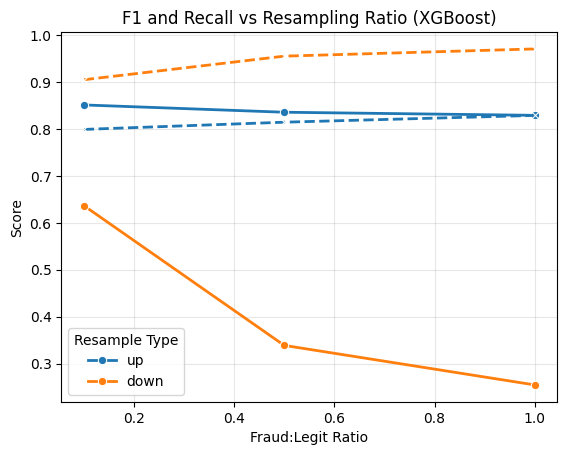


--- Mean Scores Summary ---
                                   precision  recall     f1
model         ratio resample_type                          
XGB_Resampled 0.1   down               0.491   0.905  0.637
                    up                 0.911   0.799  0.851
              0.5   down               0.206   0.955  0.339
                    up                 0.858   0.814  0.836
              1.0   down               0.146   0.971  0.254
                    up                 0.829   0.829  0.829

Plots and summary complete.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating plots...")


sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type",
            marker="o", linewidth=2, legend="brief")

sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type",
            marker="x", linestyle="--", linewidth=2, legend=False)


plt.title("F1 and Recall vs Resampling Ratio (XGBoost)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/xgboost_f1_recall_plot.png")
plt.show()

summary = results_df.groupby(["model", "ratio", "resample_type"])[["precision", "recall", "f1"]].mean().round(3)
print("\n--- Mean Scores Summary ---")
print(summary)

print("\nPlots and summary complete.")